In [26]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt

os.chdir('C:/Users/fando/Box Sync/Springboard/Capstone Project/Data')

In [2]:
dtype_dict_ready = np.load('dtype_dict_ready.npy').item()
allData = pd.read_csv('allData_ready.txt', sep=" ", dtype = dtype_dict_ready, encoding = "ISO-8859-1")
allData.drop(['book_day'], axis=1, inplace=True)

# I. Predict the future
Train a model using 2015 and 2016's data and predict 2017's availability.

Based on what we learned from Model Fitting, we will use XGBoost Classifier here.

### Predict 2017 Quarter 1

In [96]:
dat_1516 = allData[allData['book_year']!='2017']
dat_17 = allData[allData['book_year']=='2017']

In [97]:
X = dat_1516.drop('target', axis=1)
y = dat_1516['target']

In [5]:
test = dat_17.loc[(dat_17['book_month'].isin(['1','2','3']))]
X_test = test.drop('target', axis=1)
y_test = test['target']

In [7]:
clf = xgb.XGBClassifier(n_estimators= 160, max_depth= 10, objective= 'binary:logistic', n_jobs= -1)

In [8]:
def to_int(df, var):
    df[var] = df[var].astype(int)
    return df
for var in ['book_month', 'book_year', 'book_weekday']:
    X = to_int(X, var)
    X_test = to_int(X_test, var)

In [9]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=160,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [11]:
y_pred = clf.predict_proba(X_test)
y_pred = pd.DataFrame(y_pred)

XGBoost Classifier returns the predicted probability of whether a listing will be avialable on a specific date. We need to set a threshold to turn that into a binary variable (available vs. not available). Loop over possible threshold values and find the one that maximizes the accuracy score.

In [30]:
lst = []
for i in np.arange(0.5, 1.0, 0.05):
    y_pred_bin = y_pred.iloc[:,1]>i
    score = metrics.accuracy_score(y_test, y_pred_bin)
    lst.append([i,score])
lst = pd.DataFrame(lst)

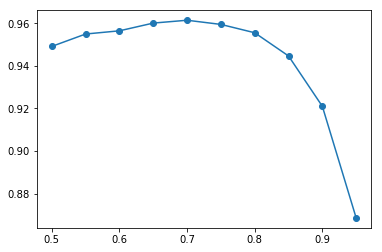

In [35]:
plt.plot(lst.iloc[:,0], lst.iloc[:,1],'-o')
plt.show()

As the plot above shows, we obtain highest accuracy score when the threshold = 0.7.

Thus, using 16 months of Airbnb data (September 2015 ~ December 2016) as the train set, we are able to achieve an accuracy score of 0.96 when predicting 2017 Q1.

### Predict 2017 Quarter 2
Now let's use the predicted value of 2017 Q1 as part of the train set and predict 2017 Q2.

In [47]:
# Append 2017 Q1's predicted values to the train set.
y_pred_Q1 = y_pred.iloc[:,1]>0.7
y = y.append(y_pred_Q1, ignore_index=True)
X = pd.concat([X, X_test])

In [49]:
# Set up the test set.
test = dat_17.loc[(dat_17['book_month'].isin(['4','5','6']))]
X_test = test.drop('target', axis=1)
y_test = test['target']
for var in ['book_month', 'book_year', 'book_weekday']:
    X_test = to_int(X_test, var)

In [50]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=160,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [54]:
clf.score(X_test, y_test)

0.96285106859124991

In [57]:
y_pred = clf.predict_proba(X_test)
y_pred = pd.DataFrame(y_pred)   
y_pred_bin = y_pred.iloc[:,1]>0.7
metrics.accuracy_score(y_test, y_pred_bin)

0.94654246391406516

This time, the optimal threshold is 0.5, which gives us an accuracy score of 0.96. It seems like optimal threshold varies for different training/test set. 

Question: How to set a threshold? (Conservativeness, etc.)

In both Q1 and Q2 prediction, we are able to achieve an accuracy score in the high 90s, which sounds a little bit too good to be true. Let's investigate it further.

### Dig deeper into the high accuracy score

This time, let's take September 2015 ~ December 2016 as train, and January~June 2017 as test.

In [98]:
X = dat_1516.drop('target', axis=1)
y = dat_1516['target']
test = dat_17.loc[(dat_17['book_month'].isin(['1','2','3','4','5','6']))]
X_test = test.drop('target', axis=1)
y_test = test['target']
for var in ['book_month', 'book_year', 'book_weekday']:
    X = to_int(X, var)
    X_test = to_int(X_test, var)
clf.fit(X, y)
clf.score(X_test, y_test)

0.9563342166093477

If one class is in great majority, we can naturally get a high accuracy score by predicting everything to be the majority class.

In [99]:
y_pred = clf.predict_proba(X_test)
y_pred = pd.DataFrame(y_pred)   
y_pred_bin = y_pred.iloc[:,1]>0.5

In [101]:
y_test[y_test==0].count()/len(y_test)

0.71940012403450415

In our test set, 72% of the observations are 'not available', the remaining 28% are 'available'.

Then how's our accuracy rate in the 28%?

In [146]:
y_all = y_test.reset_index()
y_all['pred'] = y_pred_bin

In [84]:
# accuracy rate in the 28%
y_all.loc[(y_all['target']==1) & (y_all['pred']==1)]['target'].count()/y_test[y_test==1].count()

0.92937512557765722

In [85]:
# accuracy rate in the 72%
y_all.loc[(y_all['target']==0) & (y_all['pred']==0)]['target'].count()/y_test[y_test==0].count()

0.96684952978056427

The accuracy rate in the 'available' class is 93% and that in the 'unavailable' class is 96.7%. Uneven proportion of two classes is not the reason behind our high accuracy score.

Question: Other explanations behind high accuracy?

# II. Projected Value of a Listing

In [86]:
later_use = pd.read_csv('later.txt', sep=" ", dtype = dtype_dict_ready, encoding = "ISO-8859-1")

In [104]:
allData_avail = pd.concat([allData, later_use], axis=1)
dat_17_avail = allData_avail[allData_avail['book_year']=='2017']

In [105]:
test_avail = dat_17_avail.loc[(dat_17_avail['book_month'].isin(['1','2','3','4','5','6']))]

In [150]:
y_all = pd.concat([y_all, test_avail[['price','listing_id']].reset_index()], axis=1, ignore_index=True)
y_all.drop([0,3], axis=1, inplace=True)
y_all = y_all.rename(index=str, columns={1: "true", 2: "pred", 4:"price", 5:"listing_id"})

Reverse the 0/1 mapping of target variable. Let y=0 when 'available' and y=1 when 'unavailable', so that it is easier for listing value calculation.

In [151]:
di = {1: "a", 0: "b"}
y_all = y_all.replace({"pred": di})

In [152]:
di2 = {"a": 0, "b":1}
y_all = y_all.replace({"pred": di2})

In [153]:
y_all['revenue'] = y_all['pred']*y_all['price']

Calculate each listing's projected value in the first half of 2017.

In [158]:
revenue_id = y_all.groupby('listing_id')['revenue'].sum().reset_index()

In [167]:
revenue_id.head()

,listing_id,revenue
0,5858,0.000000
1,7918,2252.583607
2,21334,20493.622951
3,21914,1982.164948
4,23540,30152.086957


In [161]:
dat_17_avail = pd.merge(dat_17_avail, revenue_id, on=['listing_id'], how='left')

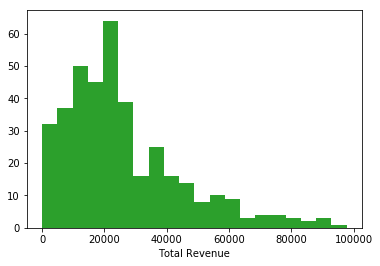

In [166]:
# Take a look at the distribution of listings' revenue.
n, bins, patches = plt.hist(revenue_id[revenue_id['revenue']<=100000]['revenue'], 20)
plt.xlabel('Total Revenue')
plt.show()